In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

In [3]:
DATA_DIR_PATH = "datasets/listeria"
META_DIR_PATH = "datasets"
PEAK_DIR_PATH = "datasets/extracted_peaks"

In [4]:
files =  os.listdir(DATA_DIR_PATH)
files = [fn  for fn in files if fn.endswith(".txt")]
files = sorted(files)
for file in files[:5] :
    print(file, file[:-4])

L100_0_G7_1.txt L100_0_G7_1
L100_0_G8_1.txt L100_0_G8_1
L101_0_A1_1.txt L101_0_A1_1
L101_0_A2_1.txt L101_0_A2_1
L102_0_A3_1.txt L102_0_A3_1


In [5]:
pk_files =  os.listdir(PEAK_DIR_PATH)
pk_files = [fn  for fn in pk_files if fn.endswith(".pkl")]
pk_files = sorted(pk_files)
for file in pk_files[:5] :
    print(file, file[:-10])

L100_0_G7_1_peaks.pkl L100_0_G7_1
L100_0_G8_1_peaks.pkl L100_0_G8_1
L101_0_A1_1_peaks.pkl L101_0_A1_1
L101_0_A2_1_peaks.pkl L101_0_A2_1
L102_0_A3_1_peaks.pkl L102_0_A3_1


In [6]:
extracted = []
for file in files:
    df = None
    df = pd.read_table(f"{DATA_DIR_PATH}/{file}",sep=" ", header=None,names=['m/z', 'intensity']) 
    x, y = df['m/z'].to_numpy(), df['intensity'].to_numpy()
    pk_file = f"{file[:-4]}_peaks.pkl"
    if pk_file not in pk_files:
        continue
    with open(f'{PEAK_DIR_PATH}/{pk_file}', 'rb') as peak_file:
        peaks = pickle.load(peak_file)
        # print(f'{file}, peaks: {len(peaks)}')
        extracted +=  [(x[peaks], y[peaks]) ] 

print(extracted[0][0][:5])
print(extracted[1][0][:5])

[1001.083 1007.932 1023.81  1044.463 1054.965]
[1001.273 1008.122 1024.29  1045.046 1055.16 ]


In [7]:
X = np.concatenate([x[0] for x in extracted])
# X = np.round(X, decimals=2)
X = np.round(X) # round to integer
X = np.sort(X)
X[-10:]

array([20069., 20069., 20070., 20070., 20070., 20070., 20071., 20071.,
       20072., 20074.])

In [8]:
def kde_align2(X, kernel_="gaussian", bandwidth_=100, n_samples_=4096, max_width_=3):
    """
    kde_align2(): alignment of values in an ordered list, 1-d clustering 
    Params:
      X: list[float], sorted list of m/z values to be aligned
      kernel_: str, kernel to use
      bandwidth_: float, bandwidth of the kernel, the larger the coarser / smoother  
      n_samples_: number of samples to generate
      max_width_: maximal tolerable width/diameter of a cluster
    returns: list[tuple(float,float, int)], list of tuples (min, max, n_members)
    """
    minval, maxval = X.min(), X.max()  
    kde = KernelDensity(kernel= kernel_, bandwidth=bandwidth_).fit(X.reshape(-1,1))
    s = np.linspace(minval, maxval, n_samples_)
    e = kde.score_samples(s.reshape(-1,1))
    mi = argrelextrema(e, np.less)[0]
    b = np.append(s[mi], maxval)
    groups = []
    minval_ = minval
    for v in b: 
        X_ = X[(X >= minval_) * (X < v)]
        if len(X_) > 0:
            if X_.max() - X_.min() <= max_width_:
                groups.append((X_.min(),X_.max(), len(X_)))
            else:
                groups += kde_align2(X_, bandwidth_=bandwidth_*0.618, max_width_=max_width_)
                
            minval_ = v
            
    X_ = X[(X >= minval_)]
    if len(X_) > 0:
        groups.append((X_.min(),X_.max(), len(X_))) 
        
    return groups


In [9]:
segments = kde_align2(X, bandwidth_=32, max_width_=3)
len(segments)

4111

In [10]:
from pprint import pprint 
pprint(segments[:20])
print("*" * 20)
pprint(segments[-20:])

[(1001.0, 1002.0, 33),
 (1007.0, 1009.0, 74),
 (1017.0, 1017.0, 12),
 (1018.0, 1018.0, 2),
 (1023.0, 1023.0, 2),
 (1024.0, 1024.0, 30),
 (1025.0, 1025.0, 12),
 (1032.0, 1033.0, 3),
 (1044.0, 1047.0, 52),
 (1049.0, 1049.0, 1),
 (1053.0, 1054.0, 32),
 (1055.0, 1055.0, 67),
 (1056.0, 1056.0, 2),
 (1062.0, 1065.0, 32),
 (1066.0, 1066.0, 3),
 (1074.0, 1074.0, 1),
 (1075.0, 1075.0, 1),
 (1076.0, 1076.0, 2),
 (1077.0, 1078.0, 6),
 (1086.0, 1088.0, 36)]
********************
[(20027.0, 20027.0, 1),
 (20031.0, 20031.0, 1),
 (20035.0, 20035.0, 1),
 (20039.0, 20041.0, 4),
 (20043.0, 20045.0, 4),
 (20047.0, 20047.0, 1),
 (20048.0, 20048.0, 1),
 (20051.0, 20051.0, 1),
 (20055.0, 20058.0, 3),
 (20059.0, 20059.0, 2),
 (20062.0, 20063.0, 2),
 (20065.0, 20065.0, 1),
 (20066.0, 20066.0, 2),
 (20067.0, 20067.0, 3),
 (20068.0, 20068.0, 3),
 (20069.0, 20069.0, 10),
 (20070.0, 20070.0, 4),
 (20071.0, 20071.0, 2),
 (20072.0, 20072.0, 1),
 (20074.0, 20074.0, 1)]


In [11]:
import matplotlib.pyplot as plt

In [37]:
minval, maxval = X.min(), X.max()  
n_samples_ = 4096
s = np.linspace(minval, maxval, n_samples_)
kde = KernelDensity(kernel= "gaussian", bandwidth=256).fit(X.reshape(-1,1))
e1 = kde.score_samples(s.reshape(-1,1))
mi1 = argrelextrema(e1, np.less)[0]
kde = KernelDensity(kernel= "gaussian", bandwidth=256*0.382).fit(X.reshape(-1,1))
e2 = kde.score_samples(s.reshape(-1,1))
mi2 = argrelextrema(e2, np.less)[0]


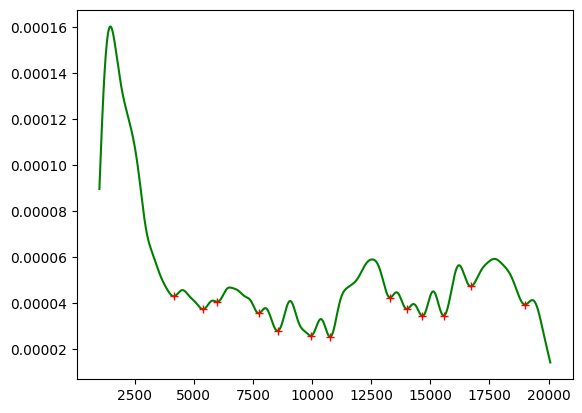

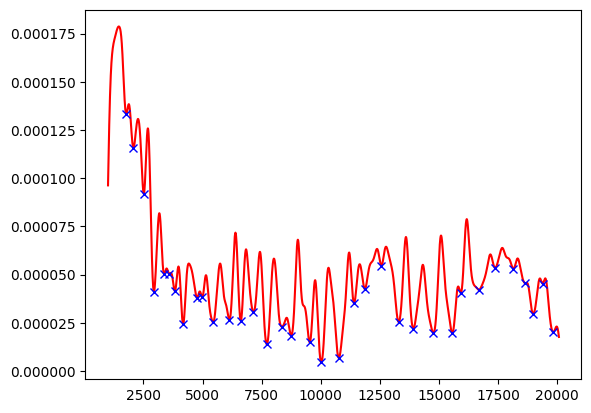

In [38]:
s_ = s[:5000]
plt.plot(s_, np.exp(e1), 'g')
plt.plot(s_[mi1], np.exp(e1[mi1]), 'r+')
plt.show()
plt.plot(s_, np.exp(e2), 'r',
        s_[mi2], np.exp(e2[mi2]), 'bx')
plt.show()

In [39]:
pprint(s[mi1])
pprint(s[mi2])

array([ 4144.9010989 ,  5383.83101343,  5989.32307692,  7740.59242979,
        8537.04737485,  9938.99438339, 10758.73748474, 13297.14652015,
       14005.10647131, 14666.49010989, 15565.41294261, 16711.19023199,
       19007.402442  ])
array([ 1774.16678877,  2076.91282051,  2514.73015873,  2943.23223443,
        3376.39194139,  3599.95824176,  3828.18217338,  4177.5045177 ,
        4769.02368742,  4987.93235653,  5449.03785104,  6133.70964591,
        6618.1032967 ,  7153.73089133,  7717.3042735 ,  8355.3997558 ,
        8746.64078144,  9533.78046398, 10022.83174603, 10763.395116  ,
       11410.80586081, 11862.5960928 , 12565.8984127 , 13297.14652015,
       13916.61147741, 14764.3003663 , 15565.41294261, 15924.05054945,
       16687.9020757 , 17377.23150183, 18150.3982906 , 18653.42246642,
       18988.77191697, 19384.67057387, 19836.46080586])
